In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader


In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

# Define both dataset paths
drive_t1 = '/content/drive/MyDrive/dataset_t1_new'
drive_t2 = '/content/drive/MyDrive/dataset_t2_new'

# Local paths
local_t1 = '/content/dataset_t1_new'
local_t2 = '/content/dataset_t2_new'

# Copy T1
if not os.path.exists(local_t1):
    shutil.copytree(drive_t1, local_t1)
    print("Copied T1 dataset")
else:
    print("T1 dataset already exists")

# Copy T2
if not os.path.exists(local_t2):
    shutil.copytree(drive_t2, local_t2)
    print("Copied T2 dataset")
else:
    print("T2 dataset already exists")

# Count and print total image files
def count_images_in_folder(folder_path):
    total = 0
    for subdir, _, files in os.walk(folder_path):
        total += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total

t1_count = count_images_in_folder(local_t1)
t2_count = count_images_in_folder(local_t2)

print(f"T1 images: {t1_count}")
print(f"T2 images: {t2_count}")


Mounted at /content/drive
Copied T1 dataset
Copied T2 dataset
T1 images: 14203
T2 images: 13522


In [ ]:
train_transform = transforms.Compose([
     transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import ConcatDataset, random_split

# Load both datasets with transform
# We will use val_test_transform for validation and test datasets
t1_dataset_train = ImageFolder(root=local_t1, transform=train_transform)
t2_dataset_train = ImageFolder(root=local_t2, transform=train_transform)

t1_dataset_val_test = ImageFolder(root=local_t1, transform=val_test_transform)
t2_dataset_val_test = ImageFolder(root=local_t2, transform=val_test_transform)


# Make sure both datasets are balanced by size (50/50) for the training split
min_len = min(len(t1_dataset_train), len(t2_dataset_train))
t1_balanced_train, _ = random_split(t1_dataset_train, [min_len, len(t1_dataset_train) - min_len])
t2_balanced_train, _ = random_split(t2_dataset_train, [min_len, len(t2_dataset_train) - min_len])

# Merge datasets for the training split
full_dataset_train = ConcatDataset([t1_balanced_train, t2_balanced_train])

# Combine class labels and get indices for the combined training dataset
# The class_to_idx should be consistent across both datasets, so we can use one
class_to_idx = t1_dataset_train.class_to_idx

# Get targets from the balanced subsets for splitting
targets_train = np.array(t1_balanced_train.dataset.targets[:min_len] + t2_balanced_train.dataset.targets[:min_len])

# Create index lists for the combined training dataset based on their original indices
# These indices refer to the positions within the full_dataset_train
false_idx = np.where(targets_train == class_to_idx['false'])[0]
true_idx  = np.where(targets_train == class_to_idx['true'])[0]
np.random.seed(42)
np.random.shuffle(false_idx)
np.random.shuffle(true_idx)

# Split function
def split(indices):
    total = len(indices)
    train_size = int(0.7 * total)
    val_size = int(0.2 * total)
    train = indices[:train_size]
    val = indices[train_size:train_size + val_size]
    test = indices[train_size + val_size:]
    return train, val, test

# Split by class
false_train, false_val, false_test = split(false_idx)
true_train,  true_val,  true_test  = split(true_idx)

# Merge class splits to get indices for the overall train, val, and test sets from the balanced combined dataset
train_idx = np.concatenate([false_train, true_train])
val_idx   = np.concatenate([false_val, true_val])
test_idx  = np.concatenate([false_test, true_test])

# Create datasets using Subsets of the appropriate full dataset
# The training dataset uses the full_dataset_train (with train transforms)
train_dataset = Subset(full_dataset_train, train_idx)

# Create a full dataset with val/test transforms for validation and testing
full_dataset_val_test = ConcatDataset([t1_dataset_val_test, t2_dataset_val_test])

# The validation and test datasets use the full_dataset_val_test (with val_test transforms) and the indices derived from the balanced split
# This is the key change: val_dataset and test_dataset should be subsets of the concatenated dataset,
# not just one of the original ImageFolders.
val_dataset   = Subset(full_dataset_val_test, val_idx)
test_dataset  = Subset(full_dataset_val_test, test_idx)


# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Shuffle should be False for validation and test loaders
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the size of the datasets and loaders
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print(f"Train loader batches: {len(train_loader)}")
print(f"Validation loader batches: {len(val_loader)}")
print(f"Test loader batches: {len(test_loader)}")

Train dataset size: 18930
Validation dataset size: 5408
Test dataset size: 2706
Train loader batches: 296
Validation loader batches: 85
Test loader batches: 43


In [ ]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained DenseNet121
model = models.densenet121(pretrained=True)

# Freeze all feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze only the last dense block and final normalization layer
for name, param in model.features.named_parameters():
    if 'denseblock4' in name or 'norm5' in name:
        param.requires_grad = True

# Replace classifier with a custom head for binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 2))

# Move model to device
model.to(device)

# Define loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Adam optimizer with low LR and weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Scheduler to reduce LR if validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

In [ ]:
# Train the model with early stopping and learning rate scheduling.
# Tracks the train and validation loss and accuracy each epoch.
# Stops training if validation loss does not improve after 'patience_limit' epochs.

num_epochs = 75
patience_limit = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")
    model.train()
    correct = total = 0
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    val_loss = val_correct = val_total = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    scheduler.step(val_epoch_loss)
    print(f"Val Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping")
            break


 Epoch 1/75


100%|██████████| 296/296 [02:33<00:00,  1.93it/s]


Train Loss: 0.6684, Accuracy: 0.5997


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.6277, Accuracy: 0.6930

 Epoch 2/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.6167, Accuracy: 0.6800


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.5924, Accuracy: 0.7071

 Epoch 3/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.5916, Accuracy: 0.7052


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.5687, Accuracy: 0.7358

 Epoch 4/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.5709, Accuracy: 0.7302


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.5464, Accuracy: 0.7592

 Epoch 5/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.5517, Accuracy: 0.7538


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.5278, Accuracy: 0.7742

 Epoch 6/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.5344, Accuracy: 0.7694


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.5083, Accuracy: 0.7922

 Epoch 7/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.5189, Accuracy: 0.7835


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.4930, Accuracy: 0.8033

 Epoch 8/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.5044, Accuracy: 0.7962


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.4779, Accuracy: 0.8206

 Epoch 9/75


100%|██████████| 296/296 [02:29<00:00,  1.98it/s]


Train Loss: 0.4860, Accuracy: 0.8079


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.4642, Accuracy: 0.8330

 Epoch 10/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.4712, Accuracy: 0.8227


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.4518, Accuracy: 0.8391

 Epoch 11/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.4584, Accuracy: 0.8337


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.4424, Accuracy: 0.8438

 Epoch 12/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.4511, Accuracy: 0.8385


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.4308, Accuracy: 0.8539

 Epoch 13/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.4359, Accuracy: 0.8474


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.4218, Accuracy: 0.8597

 Epoch 14/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.4275, Accuracy: 0.8547


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.4093, Accuracy: 0.8683

 Epoch 15/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.4195, Accuracy: 0.8595


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.4038, Accuracy: 0.8756

 Epoch 16/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.4100, Accuracy: 0.8683


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3979, Accuracy: 0.8811

 Epoch 17/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3992, Accuracy: 0.8759


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3906, Accuracy: 0.8857

 Epoch 18/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.3985, Accuracy: 0.8765


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3817, Accuracy: 0.8933

 Epoch 19/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.3892, Accuracy: 0.8821


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3777, Accuracy: 0.8939

 Epoch 20/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3821, Accuracy: 0.8876


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3722, Accuracy: 0.8959

 Epoch 21/75


100%|██████████| 296/296 [02:32<00:00,  1.95it/s]


Train Loss: 0.3768, Accuracy: 0.8929


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3685, Accuracy: 0.8992

 Epoch 22/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3708, Accuracy: 0.8993


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3614, Accuracy: 0.9075

 Epoch 23/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3617, Accuracy: 0.9060


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3611, Accuracy: 0.9077

 Epoch 24/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3580, Accuracy: 0.9068


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3526, Accuracy: 0.9125

 Epoch 25/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3553, Accuracy: 0.9080


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3487, Accuracy: 0.9140

 Epoch 26/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.3529, Accuracy: 0.9090


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3470, Accuracy: 0.9168

 Epoch 27/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3487, Accuracy: 0.9144


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3426, Accuracy: 0.9179

 Epoch 28/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3428, Accuracy: 0.9165


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3388, Accuracy: 0.9216

 Epoch 29/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3421, Accuracy: 0.9169


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3363, Accuracy: 0.9222

 Epoch 30/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3343, Accuracy: 0.9243


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3353, Accuracy: 0.9246

 Epoch 31/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3322, Accuracy: 0.9249


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3304, Accuracy: 0.9277

 Epoch 32/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3292, Accuracy: 0.9263


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3272, Accuracy: 0.9327

 Epoch 33/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3260, Accuracy: 0.9293


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3285, Accuracy: 0.9275

 Epoch 34/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3239, Accuracy: 0.9330


100%|██████████| 85/85 [00:33<00:00,  2.54it/s]


Val Loss: 0.3216, Accuracy: 0.9332

 Epoch 35/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3206, Accuracy: 0.9326


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3239, Accuracy: 0.9295

 Epoch 36/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.3181, Accuracy: 0.9333


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3142, Accuracy: 0.9379

 Epoch 37/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3128, Accuracy: 0.9384


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3158, Accuracy: 0.9351

 Epoch 38/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3110, Accuracy: 0.9426


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3123, Accuracy: 0.9373

 Epoch 39/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3107, Accuracy: 0.9414


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.3144, Accuracy: 0.9384

 Epoch 40/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3081, Accuracy: 0.9423


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3114, Accuracy: 0.9377

 Epoch 41/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3066, Accuracy: 0.9444


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3076, Accuracy: 0.9403

 Epoch 42/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.3039, Accuracy: 0.9452


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.3053, Accuracy: 0.9427

 Epoch 43/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3030, Accuracy: 0.9439


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3039, Accuracy: 0.9442

 Epoch 44/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.3001, Accuracy: 0.9476


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.3041, Accuracy: 0.9447

 Epoch 45/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2971, Accuracy: 0.9500


100%|██████████| 85/85 [00:33<00:00,  2.53it/s]


Val Loss: 0.3022, Accuracy: 0.9467

 Epoch 46/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.2952, Accuracy: 0.9511


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2985, Accuracy: 0.9475

 Epoch 47/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2912, Accuracy: 0.9543


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2986, Accuracy: 0.9491

 Epoch 48/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2914, Accuracy: 0.9548


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2954, Accuracy: 0.9504

 Epoch 49/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2909, Accuracy: 0.9553


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2934, Accuracy: 0.9521

 Epoch 50/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2898, Accuracy: 0.9557


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2899, Accuracy: 0.9538

 Epoch 51/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2897, Accuracy: 0.9549


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2925, Accuracy: 0.9521

 Epoch 52/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2848, Accuracy: 0.9594


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2908, Accuracy: 0.9530

 Epoch 53/75


100%|██████████| 296/296 [02:31<00:00,  1.95it/s]


Train Loss: 0.2818, Accuracy: 0.9597


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2889, Accuracy: 0.9543

 Epoch 54/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2822, Accuracy: 0.9588


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2874, Accuracy: 0.9543

 Epoch 55/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2795, Accuracy: 0.9612


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2854, Accuracy: 0.9553

 Epoch 56/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2809, Accuracy: 0.9619


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2863, Accuracy: 0.9536

 Epoch 57/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2765, Accuracy: 0.9627


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2819, Accuracy: 0.9573

 Epoch 58/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2778, Accuracy: 0.9626


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2791, Accuracy: 0.9604

 Epoch 59/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2769, Accuracy: 0.9618


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2802, Accuracy: 0.9582

 Epoch 60/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2773, Accuracy: 0.9624


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


Val Loss: 0.2795, Accuracy: 0.9608

 Epoch 61/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2728, Accuracy: 0.9654


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2799, Accuracy: 0.9621

 Epoch 62/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2732, Accuracy: 0.9647


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2832, Accuracy: 0.9588

 Epoch 63/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2685, Accuracy: 0.9684


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2748, Accuracy: 0.9626

 Epoch 64/75


100%|██████████| 296/296 [02:31<00:00,  1.96it/s]


Train Loss: 0.2692, Accuracy: 0.9688


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2767, Accuracy: 0.9625

 Epoch 65/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2691, Accuracy: 0.9659


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2756, Accuracy: 0.9621

 Epoch 66/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2700, Accuracy: 0.9654


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2752, Accuracy: 0.9602

 Epoch 67/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2684, Accuracy: 0.9670


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2750, Accuracy: 0.9626

 Epoch 68/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2676, Accuracy: 0.9693


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2748, Accuracy: 0.9630

 Epoch 69/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2674, Accuracy: 0.9677


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2746, Accuracy: 0.9619

 Epoch 70/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2690, Accuracy: 0.9687


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.2733, Accuracy: 0.9630

 Epoch 71/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2683, Accuracy: 0.9691


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2748, Accuracy: 0.9632

 Epoch 72/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2688, Accuracy: 0.9672


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


Val Loss: 0.2743, Accuracy: 0.9625

 Epoch 73/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2686, Accuracy: 0.9691


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


Val Loss: 0.2752, Accuracy: 0.9612

 Epoch 74/75


100%|██████████| 296/296 [02:30<00:00,  1.97it/s]


Train Loss: 0.2689, Accuracy: 0.9685


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]


Val Loss: 0.2734, Accuracy: 0.9630

 Epoch 75/75


100%|██████████| 296/296 [02:30<00:00,  1.96it/s]


Train Loss: 0.2660, Accuracy: 0.9701


100%|██████████| 85/85 [00:33<00:00,  2.56it/s]

Val Loss: 0.2739, Accuracy: 0.9626
Early stopping


In [ ]:
# Final evaluation on test set
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_loss /= test_total
test_acc = test_correct / test_total
print(f"\n Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")



 Test Loss: 0.2705, Accuracy: 0.9667



Confusion Matrix:
[[1366   34]
 [  56 1250]]
Accuracy : 0.9667
Precision: 0.9735
Recall   : 0.9571
F1 Score : 0.9653


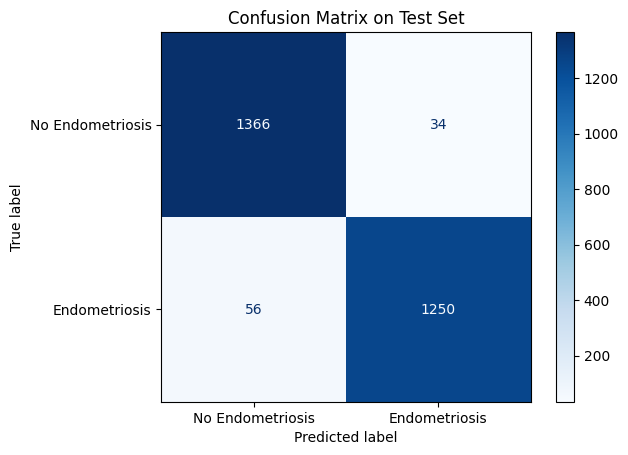

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Collect all true and predicted labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

# Compute metrics
accuracy  = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
f1        = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print results
print(f"\nConfusion Matrix:\n{cm}")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Endometriosis", "Endometriosis"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()


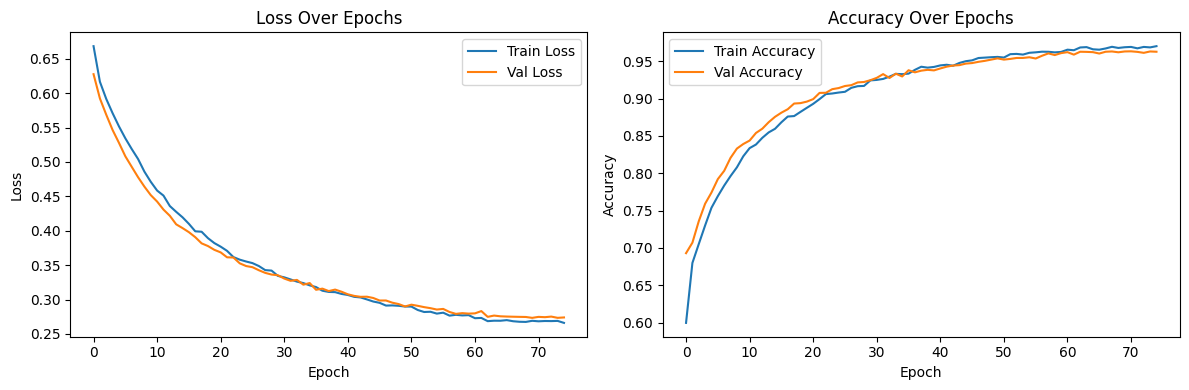

In [ ]:
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
from PIL import Image
import io
import torch.nn.functional as F
import matplotlib.pyplot as plt # Import matplotlib

# Prompt user to upload an image
print("Upload an image to classify:")
uploaded = files.upload()

# Check for uploaded image
if uploaded:
    for fname in uploaded:
        # Load and preprocess image
        image = Image.open(io.BytesIO(uploaded[fname])).convert('RGB')
        plt.imshow(image)
        plt.title("Uploaded Image")
        plt.axis('off')
        plt.show()

        # Apply test transform (resize, normalize)
        input_tensor = val_test_transform(image).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            _, prediction = torch.max(probs, 1)
            confidence = probs[0][prediction].item()

        # Map index to label
        # Use class_to_idx from one of the original ImageFolder datasets
        # before concatenation, as ConcatDataset does not have this attribute.
        idx_to_class = {v: k for k, v in t1_dataset_val_test.class_to_idx.items()}
        predicted_label = idx_to_class[prediction.item()]

        print(f"Prediction: {predicted_label.upper()}  (Confidence: {confidence:.2%})")